# Thyroid Disease classification problem

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, classification_report, roc_curve, auc, f1_score

### Import data considering gaps (empty spaces)

In [4]:
df = pd.read_csv("thyroid.csv", sep =', ')

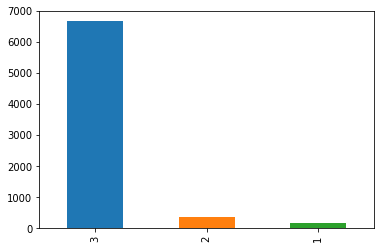

In [5]:
'''
Three classes are not well-balanced, so that prediction 
could be not relevant for classes where overall amount is less(1,2 classes) 
'''
pd.value_counts(df['Class']).plot.bar()

In [6]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Trying to fit data into simplest Logistic Regression

In [8]:
logreg = LogisticRegression()
results = logreg.fit(X_train, y_train).predict(X_test)

In [9]:
accuracy_score(results, y_test)

0.9277777777777778

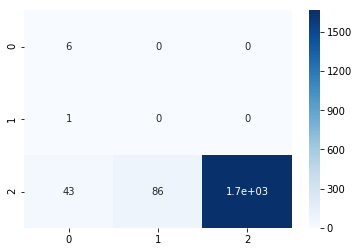

In [10]:
sns.heatmap(confusion_matrix(results, y_test), cmap="Blues", annot=True)

In [11]:
print(classification_report(results, y_test))

             precision    recall  f1-score   support

          1       0.12      1.00      0.21         6
          2       0.00      0.00      0.00         1
          3       1.00      0.93      0.96      1793

avg / total       1.00      0.93      0.96      1800



But here we see that Confusion matrix diagonal value is relevant only for 3rd class, so that we should balance our target.

In [10]:
def pca(n_components, X_train, X_test, whiten=True):
    pca = PCA(n_components=n_components, whiten=whiten).fit(X_train)
    return pca.transform(X_train), pca.transform(X_test)

In [11]:
def best_pca(b, e, coef, X_train, X_test, y_train, y_test):
    n_range, n_scores = [], [] 
    
    for i in range(b, e+1):
        n_range.append(i)
        X_train_pca, X_test_pca = pca(i, X_train, X_test)
        n_scores.append(knn(best_k, X_train_pca, X_test_pca, y_train, y_test, silence=True)[1])
        
    best_n_i = [i for i, j in enumerate(n_scores) if j == max(n_scores)][0]
    return n_range[best_n_i]

In [12]:
def knn(k, X_train, X_test, y_train, y_test, silence=False):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if not silence:
        print("\nkNN accuracy: {:.3f}".format(accuracy))
        print("Number of correct preds: {} / {}".format(np.sum(y_pred == y_test), len(y_test)))
    return y_pred, accuracy

In [13]:
def svc(X_train, X_test, y_train, y_test):
    C_range = 10. ** np.arange(3, 7)
    gamma_range = 10. ** np.arange(-6, -1)
    param_grid = dict(gamma=gamma_range, C=C_range)
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, verbose=2).fit(X_train, y_train)
    y_pred = clf.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    print("SVC accuracy: {:.3f}".format(accuracy))
    print("Number of correct preds: {} / {}".format(np.sum(y_pred == y_test), len(y_test)))
    return y_pred, accuracy

### Finding best k for kNN classifier


kNN accuracy: 0.927
Number of correct preds: 1668 / 1800

kNN accuracy: 0.934
Number of correct preds: 1681 / 1800

kNN accuracy: 0.936
Number of correct preds: 1684 / 1800

kNN accuracy: 0.936
Number of correct preds: 1684 / 1800

kNN accuracy: 0.933
Number of correct preds: 1679 / 1800
Best k for kNN: 5


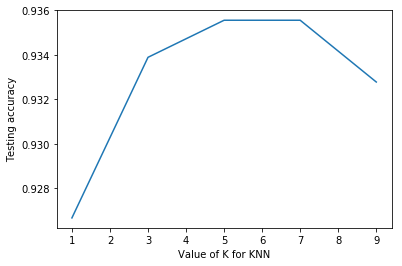

In [14]:
'''
Take the range of k-number for kNN
'''
k_range = range(1, 11, 2)

scores = [knn(k, X_train, X_test, y_train, y_test)[1] for k in k_range]
best_k = [k_range[i] for i, j in enumerate(scores) if j == max(scores)][0]

print("Best k for kNN:", best_k)
plt.plot(k_range, scores)
plt.xlabel("Value of K for KNN")
plt.ylabel("Testing accuracy")
plt.show()

Here we see that kNN classifier with k=5 has good results

Raw kNN classification

kNN accuracy: 0.936
Number of correct preds: 1684 / 1800


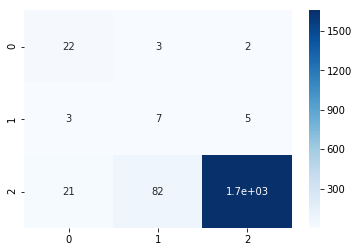

In [15]:
print("Raw kNN classification")
results = knn(best_k, X_train, X_test, y_train, y_test)[0]
sns.heatmap(confusion_matrix(results, y_test), cmap="Blues", annot=True)

### Fitting components for PCA

In [16]:
print("Finding best n-component:")
best_n_raw = best_pca(1, 21, 2, X_train, X_test, y_train, y_test)

print("\nBest n for n-components:", best_n_raw)

Finding best n-component:

Best n for n-components: 20


kNN classification with whiten PCA

kNN accuracy: 0.948
Number of correct preds: 1706 / 1800


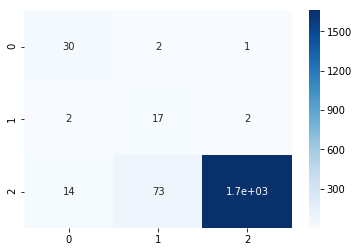

In [17]:
print("kNN classification with whiten PCA")
X_train_pca, X_test_pca = pca(best_n_raw, X_train, X_test)
results = knn(best_k, X_train_pca, X_test_pca, y_train, y_test)[0]
sns.heatmap(confusion_matrix(results, y_test), cmap="Blues", annot=True)

kNN classification with raw PCA

kNN accuracy: 0.936
Number of correct preds: 1684 / 1800


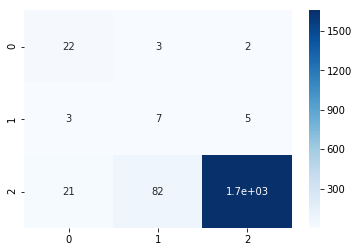

In [18]:
print("kNN classification with raw PCA")
X_train_pca, X_test_pca = pca(best_n_raw, X_train, X_test, whiten=False)
results = knn(best_k, X_train_pca, X_test_pca, y_train, y_test)[0]
sns.heatmap(confusion_matrix(results, y_test), cmap="Blues", annot=True)

Raw SV classification
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............................ C=1000.0, gamma=1e-06, total=   0.8s
[CV] C=1000.0, gamma=1e-06 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ............................ C=1000.0, gamma=1e-06, total=   0.9s
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............................ C=1000.0, gamma=1e-06, total=   0.9s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............................ C=1000.0, gamma=1e-05, total=   0.6s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............................ C=1000.0, gamma=1e-05, total=   0.6s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............................ C=1000.0, gamma=1e-05, total=   0.6s
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ........................... C=1000.0, gamma=0.0001, total=   0.3s
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ........................... C=1000.0, gamma=0.0001, total=   0.4s
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   33.6s finished


SVC accuracy: 0.982
Number of correct preds: 1767 / 1800


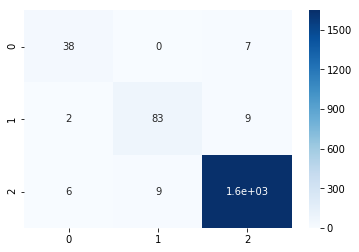

In [19]:
print("Raw SV classification")
X_train_pca, X_test_pca = pca(best_n_raw, X_train, X_test)
results = svc(X_train_pca, X_test_pca, y_train, y_test)[0]
sns.heatmap(confusion_matrix(results, y_test), cmap="Blues", annot=True)

In [20]:
print(classification_report(results, y_test))

             precision    recall  f1-score   support

          1       0.83      0.84      0.84        45
          2       0.90      0.88      0.89        94
          3       0.99      0.99      0.99      1661

avg / total       0.98      0.98      0.98      1800



In [21]:
f1_score(results, y_test, average='macro')

0.9061030112644958

In [22]:
f1_score(results, y_test, average='weighted')

0.9816553084225125

In [23]:
f1_score(results, y_test, average='micro')

0.9816666666666667

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [25]:
C_range = 10. ** np.arange(3, 7)
gamma_range = 10. ** np.arange(-6, -1)
param_grid = dict(gamma=gamma_range, C=C_range)
clf1 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
clf4 = KNeighborsClassifier(n_neighbors=best_k)
clf5 = LogisticRegression()

In [26]:
eclf1 = VotingClassifier(estimators=[('sv', clf1), ('rf', clf2), ('gnb', clf3), ('kn', clf4), ('lr', clf5)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)

/Users/dosya/Projects/lab_iis/jupyter/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


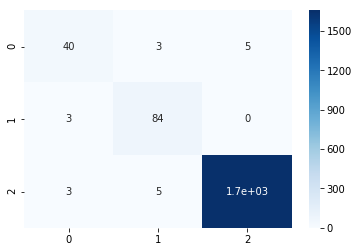

In [27]:
y_pred = eclf1.predict(X_test)
sns.heatmap(confusion_matrix(y_pred, y_test), cmap="Blues", annot=True)

In [28]:
f1_score(y_pred, y_test, average='macro')

0.9285679639049843

In [29]:
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          1       0.87      0.83      0.85        48
          2       0.91      0.97      0.94        87
          3       1.00      1.00      1.00      1665

avg / total       0.99      0.99      0.99      1800



In [33]:
accuracy_score(y_pred, y_test)

0.9894444444444445